# U-Net

In [1]:
from models.unet import create_unet

unet = create_unet()
unet.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
contracting_block_64_conv1 (Con (None, 512, 512, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
contracting_block_64_conv2 (Con (None, 512, 512, 64) 36928       contracting_block_64_conv1[0][0] 
__________________________________________________________________________________________________
contracting_block_64_pool (MaxP (None, 256, 256, 64) 0           contracting_block_64_conv2[0][0] 
_______________________________________________________________________________________________

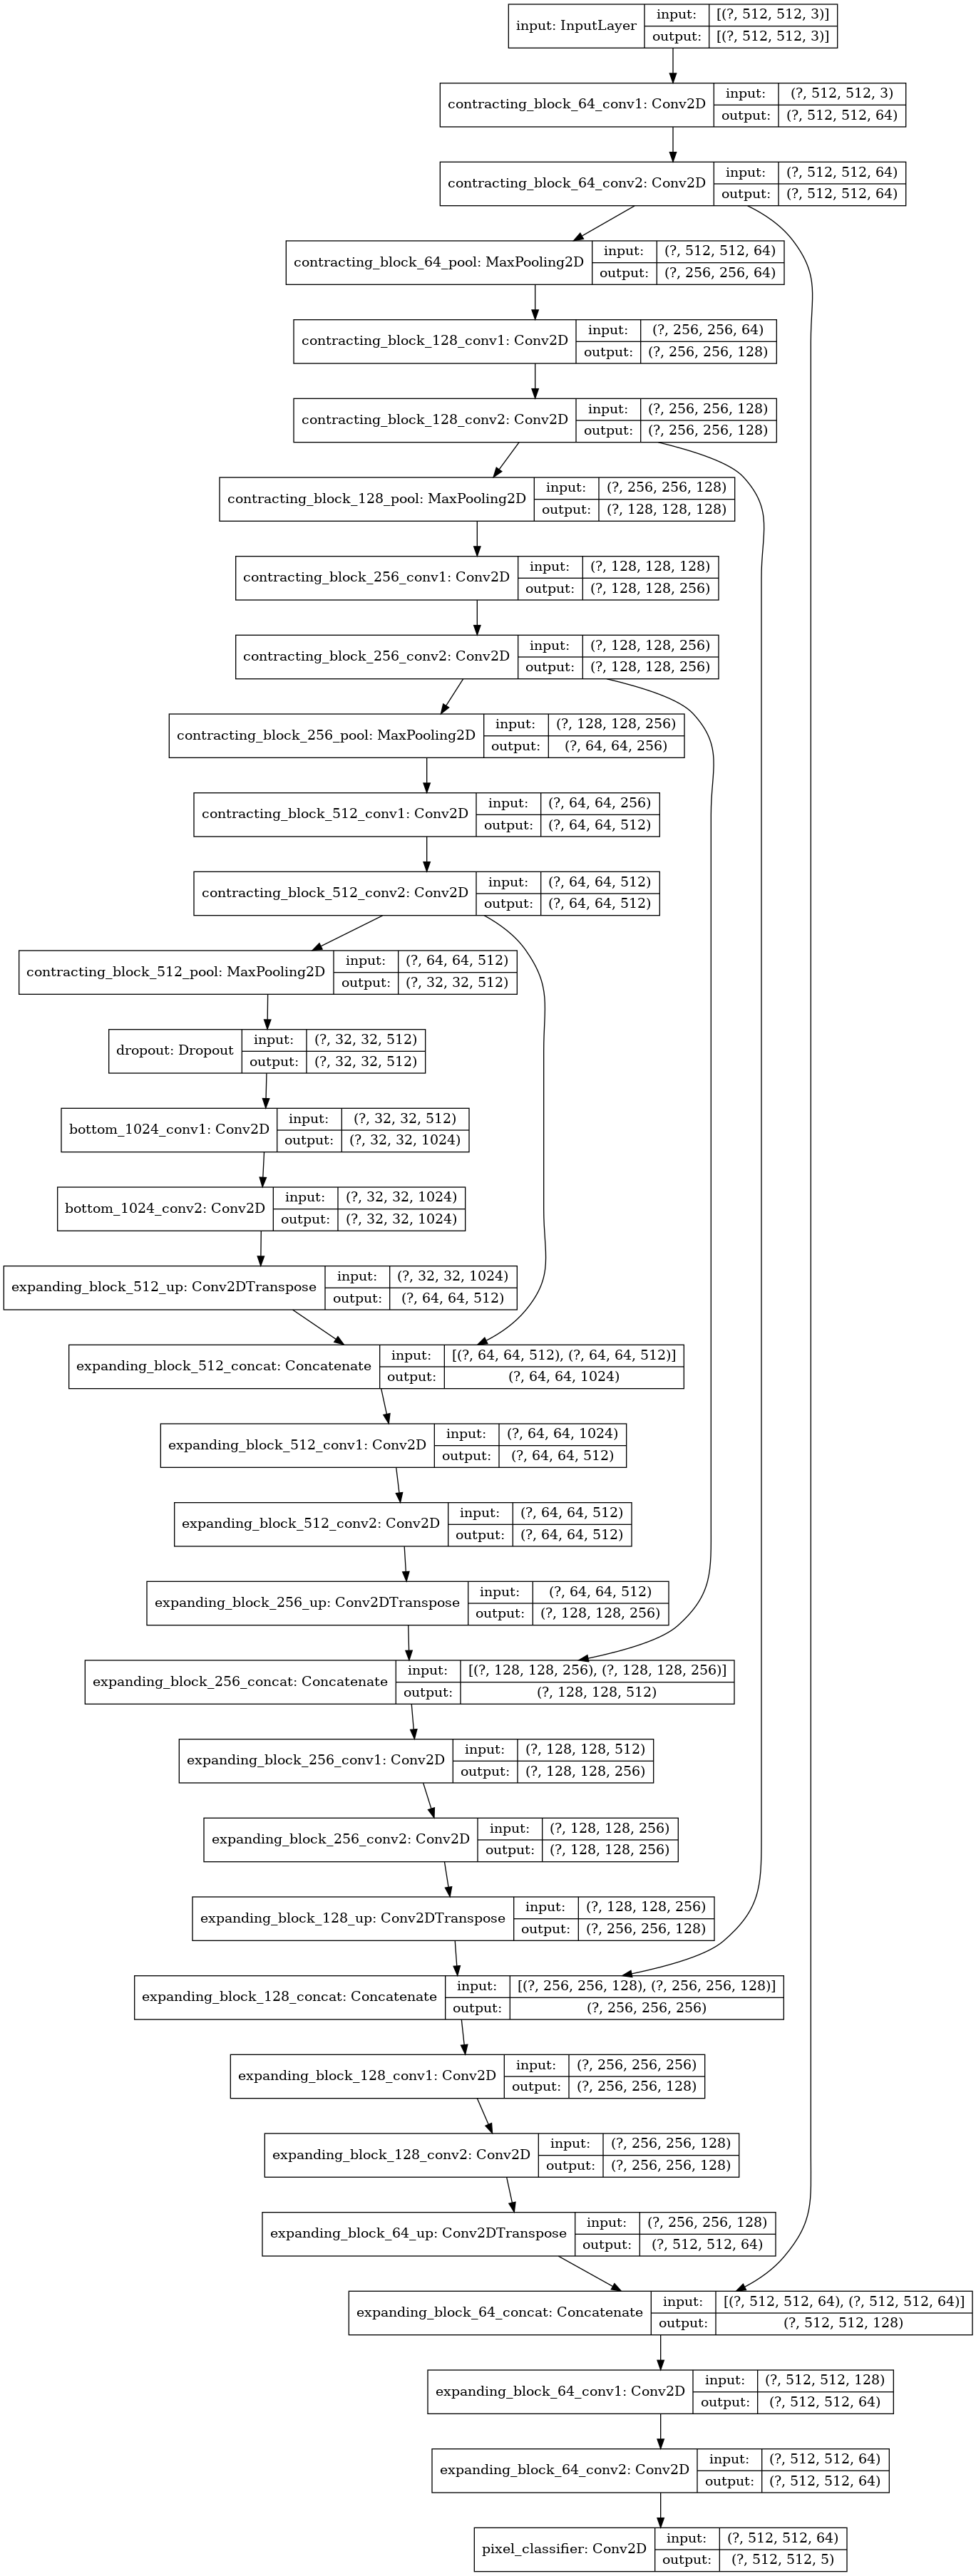

In [2]:
import tensorflow as tf

tf.keras.utils.plot_model(unet, show_layer_names=True, show_shapes=True)

In [3]:
import wandb

wandb.init(project='unet-baseline', config={
    'unet_loss': 'categorical_crossentropy',
    'unet_optimizer': 'adam',
    'batch_size': 3,
})
hparams = wandb.config

wandb: Currently logged in as: vassilis_krikonis (use `wandb login --relogin` to force relogin)
/root/.local/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
from metrics import CategoricalMeanIou

unet.compile(
    loss=hparams['unet_loss'],
    optimizer=hparams['unet_optimizer'],
    metrics=[CategoricalMeanIou(num_classes=5), 'accuracy']
)

In [5]:
!mkdir -p /tmp/ds_cache/
from datasets.skyline12 import Skyline12

skyline12 = Skyline12('datasets/skyline12/data/')

def keep_xy(x, y, z):
    return x,y

FOLDS = 2
train_ds = skyline12 \
    .as_tf_dataset(FOLDS, subset='training', cache_dir='/tmp/ds_cache/') \
    .map(keep_xy)
val_ds = skyline12 \
    .as_tf_dataset(FOLDS, subset='validation', cache_dir='/tmp/ds_cache/') \
    .map(keep_xy)

In [6]:
!mkdir -p logs
from tensorflow.keras.callbacks import \
    TerminateOnNaN, TensorBoard, EarlyStopping, ModelCheckpoint
from utils import get_new_logdir
from tensorflow.data.experimental import AUTOTUNE
from os.path import join
from callbacks import LogImages, LogImagesWandb
from wandb.keras import WandbCallback

log_dir = get_new_logdir(root_dir='./logs')
batch_size = hparams['batch_size']
unet.fit(
    train_ds.batch(batch_size).prefetch(AUTOTUNE),
    epochs=3,
    validation_data=val_ds.batch(batch_size).prefetch(AUTOTUNE),
    callbacks=[
        EarlyStopping(patience=10),
        TerminateOnNaN(),
        TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
        ),
        ModelCheckpoint(
            join(log_dir, 'model-best.h5'), 
            save_best_only=True, 
            save_weights_only=True
        ),
        LogImages(log_dir, next(iter(val_ds.batch(10)))),
        LogImagesWandb(next(iter(val_ds.batch(10)))),
        WandbCallback(save_weights_only=True)
    ]
)

Epoch 1/3
      1/Unknown - 0s 86us/step - loss: 1.9035 - categorical_mean_iou: 0.0956 - accuracy: 0.2905WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
80/80 [==============================] - 41s 512ms/step - loss: 1.1885 - categorical_mean_iou: 0.1722 - accuracy: 0.5509 - val_loss: 1.0246 - val_categorical_mean_iou: 0.1555 - val_accuracy: 0.5353
Epoch 2/3
80/80 [==============================] - 38s 469ms/step - loss: 0.9504 - categorical_mean_iou: 0.2122 - accuracy: 0.6241 - val_loss: 1.0083 - val_categorical_mean_iou: 0.1753 - val_accuracy: 0.5686
Epoch 3/3
80/80 [==============================] - 38s 471ms/step - loss: 0.8687 - categorical_mean_iou: 0.2341 - accuracy: 0.6676 - val_loss: 0.8688 - val_categorical_mean_iou: 0.2197 - val_accuracy: 0.6395


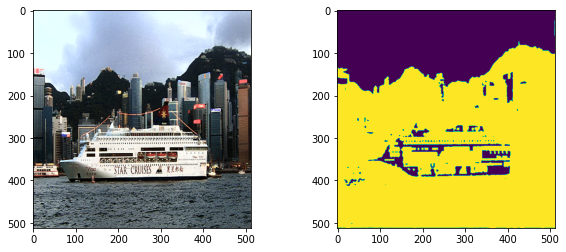

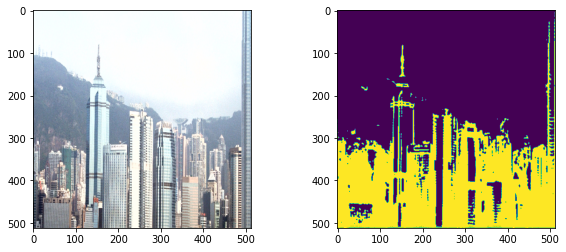

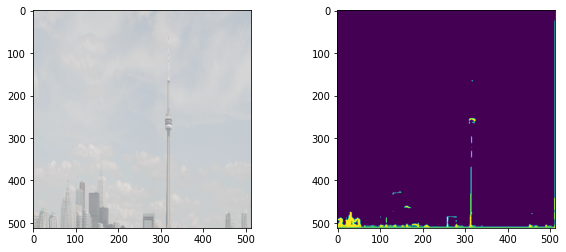

In [7]:
batch_x, _ = next(iter(val_ds.batch(3)))
preds = unet(batch_x, training=False)

for x, y_pred in zip(batch_x, preds):
    Skyline12.show_sample(x, [y_pred], from_tensors=True)